# UBER ANALYSIS FOR THE YEAR 2021 

In [1]:
import pyarrow.parquet as pq
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pylab
import os
#os.chdir("data")
import pandas as pd
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')
import time

In [2]:
data = pq.read_table('./data/fhvhv_tripdata_2021-01.parquet')
data=data.to_pandas()

# files=[file for file in os.listdir()]
# allfiles=pd.DataFrame()
# for file in files:
#     df=pq.read_table(file)
#     df=df.to_pandas()
#     allfiles=pd.concat([allfiles,df])
# allfile.to_csv("allfile.csv",index=False)

# RAW DATA

In [3]:
data.head()

,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,...,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
0,HV0003,B02682,B02682,2021-01-01 00:28:09,2021-01-01 00:31:42,2021-01-01 00:33:44,2021-01-01 00:49:07,230,166,5.26,...,1.98,2.75,NaN,0.00,14.99,N,N,,N,N
1,HV0003,B02682,B02682,2021-01-01 00:45:56,2021-01-01 00:55:19,2021-01-01 00:55:19,2021-01-01 01:18:21,152,167,3.65,...,1.63,0.00,NaN,0.00,17.06,N,N,,N,N
2,HV0003,B02764,B02764,2021-01-01 00:21:15,2021-01-01 00:22:41,2021-01-01 00:23:56,2021-01-01 00:38:05,233,142,3.51,...,1.25,2.75,NaN,0.94,12.98,N,N,,N,N
3,HV0003,B02764,B02764,2021-01-01 00:39:12,2021-01-01 00:42:37,2021-01-01 00:42:51,2021-01-01 00:45:50,142,143,0.74,...,0.70,2.75,NaN,0.00,7.41,N,N,,N,N
4,HV0003,B02764,B02764,2021-01-01 00:46:11,2021-01-01 00:47:17,2021-01-01 00:48:14,2021-01-01 01:08:42,143,78,9.20,...,2.41,2.75,NaN,0.00,22.44,N,N,,N,N


In [3]:
print(data['hvfhs_license_num'].value_counts())
uber=data[data['hvfhs_license_num']=="HV0003"]
print(uber.shape)

HV0003    8704128
HV0005    3094325
HV0004     110015
Name: hvfhs_license_num, dtype: int64
(8704128, 24)


# FEATURES ADDING / DATA TRANSFORMATION 

In [4]:
uber[['base_passenger_fare','tolls','sales_tax','congestion_surcharge', 'airport_fee', 'tips', 'driver_pay']].head()
uber['airport_fee'].fillna(0, inplace=True)
uber['date']=uber['on_scene_datetime'].dt.day
uber['hrs']=uber['pickup_datetime'].dt.hour
uber['day']=uber['pickup_datetime'].dt.day_name()
uber['uber_earnings']=uber['base_passenger_fare']+uber['tolls']+uber['congestion_surcharge']+uber['tips']-uber['driver_pay']-uber['airport_fee']+uber['sales_tax']
uber['request_datetime']=pd.to_datetime(uber['request_datetime'])
uber['pick_drop_time'] = pd.to_datetime(uber['dropoff_datetime'], format='%H:%M:%S') - pd.to_datetime(uber['pickup_datetime'], format='%H:%M:%S')
uber['request_onseen'] = pd.to_datetime(uber['on_scene_datetime'], format='%M') - pd.to_datetime(uber['request_datetime'], format='%M')
uber['base_passenger_fare'] = uber['base_passenger_fare'].abs()
uber['driver_pay']=uber['driver_pay'].abs()
uber['uber_earnings']=uber['uber_earnings'].abs()
uber.head()

,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,...,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag,date,hrs,day,uber_earnings,pick_drop_time,request_onseen
0,HV0003,B02682,B02682,2021-01-01 00:28:09,2021-01-01 00:31:42,2021-01-01 00:33:44,2021-01-01 00:49:07,230,166,5.26,...,N,,N,N,1,0,Friday,12.02,0 days 00:15:23,0 days 00:03:33
1,HV0003,B02682,B02682,2021-01-01 00:45:56,2021-01-01 00:55:19,2021-01-01 00:55:19,2021-01-01 01:18:21,152,167,3.65,...,N,,N,N,1,0,Friday,2.93,0 days 00:23:02,0 days 00:09:23
2,HV0003,B02764,B02764,2021-01-01 00:21:15,2021-01-01 00:22:41,2021-01-01 00:23:56,2021-01-01 00:38:05,233,142,3.51,...,N,,N,N,1,0,Friday,6.01,0 days 00:14:09,0 days 00:01:26
3,HV0003,B02764,B02764,2021-01-01 00:39:12,2021-01-01 00:42:37,2021-01-01 00:42:51,2021-01-01 00:45:50,142,143,0.74,...,N,,N,N,1,0,Friday,3.95,0 days 00:02:59,0 days 00:03:25
4,HV0003,B02764,B02764,2021-01-01 00:46:11,2021-01-01 00:47:17,2021-01-01 00:48:14,2021-01-01 01:08:42,143,78,9.20,...,N,,N,N,1,0,Friday,9.83,0 days 00:20:28,0 days 00:01:06


#                            UBER ANALYSIS IN JANUARRY


## TOTAL UBER EARNINGS

In [8]:
print("TOTAL EARNINGS IN JANNUARY MONTH:",locale.currency(round(uber['uber_earnings'].sum()), grouping=True))


TOTAL EARNINGS IN JANNUARY MONTH: $59,125,118.00


## TOTAL SALES TAXES COLLECTED BY NYC GOVT THROUGH UBER

In [9]:
print("TOTAL TAXES EARNED BY GOVT IN ONE MONTH",locale.currency(round(uber['sales_tax'].sum()), grouping=True))

TOTAL TAXES EARNED BY GOVT IN ONE MONTH $12,766,994.00


## TOTAL TOLLS COLLECTED IN ONE MONTH


In [10]:
print("TOTAL TAXES EARNED BY GOVT IN ONE MONTH",locale.currency(round(uber['tolls'].sum()), grouping=True))

TOTAL TAXES EARNED BY GOVT IN ONE MONTH $5,880,263.00


## WHATS THE PEAK HRS OF REQUEST ?

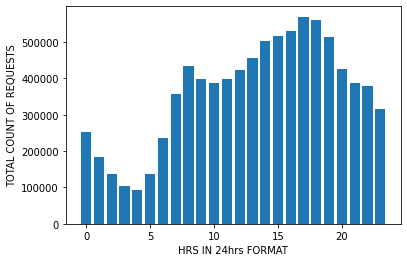

In [11]:
hrs=uber['request_datetime'].dt.hour
plt.bar(hrs.value_counts().index,hrs.value_counts().values)
plt.xlabel("HRS IN 24hrs FORMAT")
plt.ylabel("TOTAL COUNT OF REQUESTS")
plt.show()


## AT WHICH DAY THE DEMAND IS HIGH ?

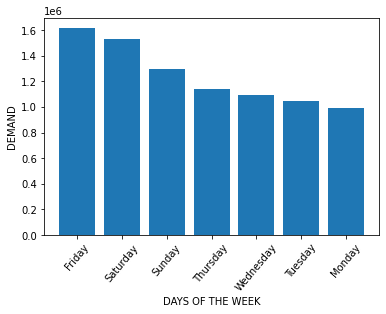

In [5]:
plt.bar(uber['day'].value_counts().index[:10],uber['day'].value_counts().values[:10])
plt.xlabel("DAYS OF THE WEEK")
plt.ylabel("DEMAND")
plt.xticks(rotation=50)
plt.show()


## WHATS MOST COMMON PICKUP AND DROP LOCATION ??

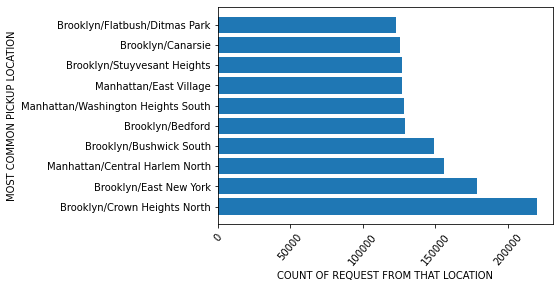

In [5]:
lookup=pd.read_csv('taxi_zone_lookup.csv')

a=data['PULocationID'].value_counts().index[:10]
b=data['PULocationID'].value_counts().values[:10]
loc=[]
for i in a:
    loc.append(lookup['loc'][i-1])
loc
plt.barh(loc,width=b)
plt.ylabel("MOST COMMON PICKUP LOCATION")
plt.xlabel("COUNT OF REQUEST FROM THAT LOCATION")
plt.xticks(rotation=50)
plt.show()

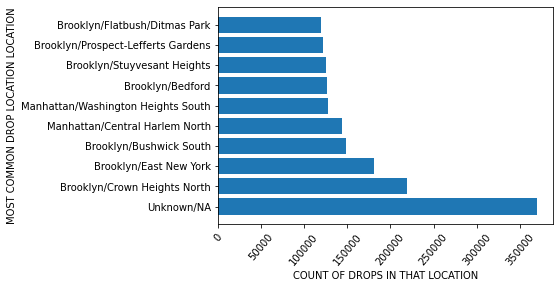

In [16]:
a=data['DOLocationID'].value_counts().index[:10]
b=data['DOLocationID'].value_counts().values[:10]
loc=[]
for i in a:
    loc.append(lookup['loc'][i-1])
loc
plt.barh(loc,width=b)
plt.ylabel("MOST COMMON DROP LOCATION LOCATION")
plt.xlabel("COUNT OF DROPS IN THAT LOCATION")
plt.xticks(rotation=50)
plt.show()

## PEAK BUSY DAYS IN JANNUARY?

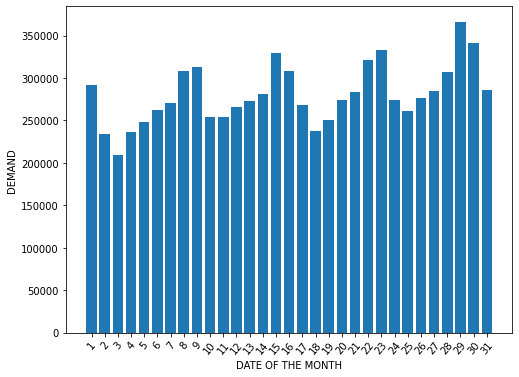

In [134]:
plt.figure(figsize=(8,6))
plt.bar(uber['date'].value_counts().index,uber['date'].value_counts().values)

plt.xlabel("DATE OF THE MONTH")
plt.ylabel("DEMAND")
plt.xticks(list(range(1,32)))
plt.xticks(rotation=90)
plt.xticks(rotation=50)

plt.show()


## what's the average time driver took to pickup passenger when they requested ?


In [25]:
uber['pick_drop_time'].mean()

Timedelta('0 days 00:15:44.927309547')

## What is there a relation between trip distance and fare amounts?

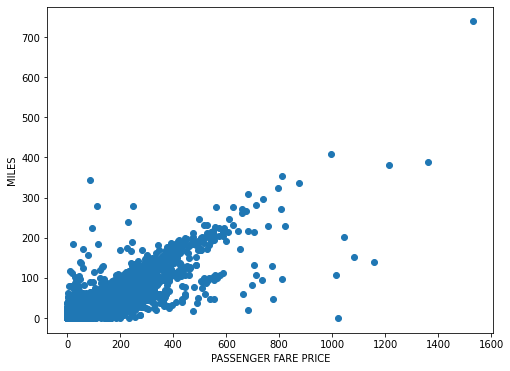

In [40]:
plt.figure(figsize=(8,6))
plt.scatter(uber['base_passenger_fare'],uber['trip_miles'])
plt.xlabel("PASSENGER FARE PRICE")
plt.ylabel("MILES")
plt.show()

## How does trip time vary based on factors like time of day or day of the week?

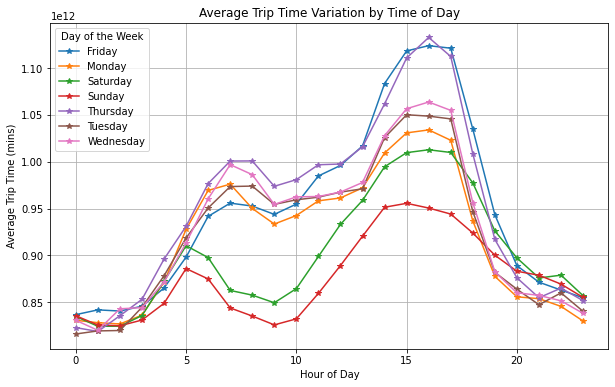

In [17]:
grouped_data=uber.groupby(['day', 'hrs'])
average_trip_time_series=grouped_data['pick_drop_time'].mean()
average_trip_time=average_trip_time_series.reset_index()
pivot_table=average_trip_time.pivot(index='hrs',columns='day',values='pick_drop_time')

plt.figure(figsize=(10,6))
for day in average_trip_time['day'].unique():
    day_data=average_trip_time[average_trip_time['day']==day]
    plt.plot(day_data['hrs'],day_data['pick_drop_time'],label=day,marker="*")

plt.title('Average Trip Time Variation by Time of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Trip Time (mins)')
plt.legend(title='Day of the Week',loc='upper left')
plt.grid(True)
plt.show()

In [41]:
uber.columns

Index(['hvfhs_license_num', 'dispatching_base_num', 'originating_base_num',
       'request_datetime', 'on_scene_datetime', 'pickup_datetime',
       'dropoff_datetime', 'PULocationID', 'DOLocationID', 'trip_miles',
       'trip_time', 'base_passenger_fare', 'tolls', 'bcf', 'sales_tax',
       'congestion_surcharge', 'airport_fee', 'tips', 'driver_pay',
       'shared_request_flag', 'shared_match_flag', 'access_a_ride_flag',
       'wav_request_flag', 'wav_match_flag', 'date', 'hrs', 'day',
       'pick_drop_time', 'request_onseen', 'uber_earnings'],
      dtype='object')

## BOXPLOT TO UNDERSTAND PEAK TIMES 

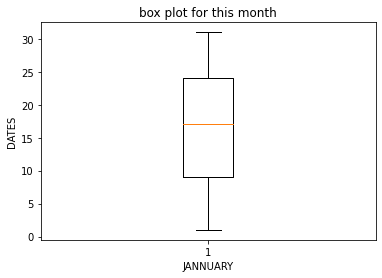

In [118]:
plt.boxplot(uber['date'])
plt.ylabel('DATES')
plt.xlabel("JANNUARY")
plt.title("box plot for this month")
plt.show()


# Whats the CORELATION between the features ??


,trip_miles,trip_time,base_passenger_fare,tolls,sales_tax,congestion_surcharge,tips,driver_pay,date,hrs,uber_earnings
trip_miles,1.000000,0.815984,0.904130,0.489399,0.748977,0.076168,0.178147,0.922029,-0.020886,-0.030991,0.628638
trip_time,0.815984,1.000000,0.831233,0.384894,0.747459,0.130267,0.166682,0.891850,0.004356,0.016505,0.530221
base_passenger_fare,0.904130,0.831233,1.000000,0.473399,0.793438,0.132141,0.221878,0.932936,-0.024559,-0.018729,0.777494
tolls,0.489399,0.384894,0.473399,1.000000,0.183105,0.014655,0.127900,0.464965,-0.006620,-0.008798,0.612010
sales_tax,0.748977,0.747459,0.793438,0.183105,1.000000,0.197784,0.174577,0.771369,-0.027037,-0.020288,0.574514
congestion_surcharge,0.076168,0.130267,0.132141,0.014655,0.197784,1.000000,0.112998,0.110220,0.031106,0.014927,0.297686
tips,0.178147,0.166682,0.221878,0.127900,0.174577,0.112998,1.000000,0.200913,0.003706,-0.004208,0.425032
driver_pay,0.922029,0.891850,0.932936,0.464965,0.771369,0.110220,0.200913,1.000000,-0.015577,-0.011468,0.608232
date,-0.020886,0.004356,-0.024559,-0.006620,-0.027037,0.031106,0.003706,-0.015577,1.000000,0.029400,-0.018601
hrs,-0.030991,0.016505,-0.018729,-0.008798,-0.020288,0.014927,-0.004208,-0.011468,0.029400,1.000000,-0.021936


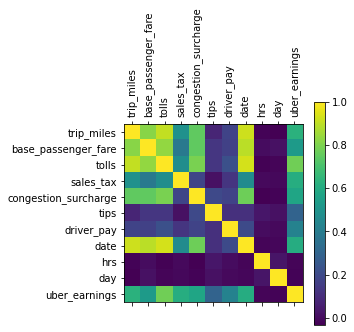

In [35]:
c=uber[['trip_miles',
       'trip_time', 'base_passenger_fare', 'tolls','sales_tax',
       'congestion_surcharge','tips', 'driver_pay', 'date', 'hrs', 'day',
       'pick_drop_time', 'request_onseen', 'uber_earnings']].corr()
we=plt.matshow(c)
plt.colorbar(we)
labels =['trip_miles', 'base_passenger_fare', 'tolls','sales_tax',
       'congestion_surcharge','tips', 'driver_pay', 'date', 'hrs', 'day', 'uber_earnings']
plt.yticks(np.arange(len(labels)), labels)
plt.xticks(np.arange(len(labels)), labels)
plt.xticks(rotation=90)
c

## CORELATION BETWEEN WEATHER DATA

,humidity,visibility,precip,snow,snowdepth,windspeed,cloudcover,temp
humidity,1.000000,-0.612629,0.350970,0.068964,-0.018511,-0.170986,0.696128,0.249578
visibility,-0.612629,1.000000,-0.450561,-0.403306,-0.198394,-0.064097,-0.499583,0.074539
precip,0.350970,-0.450561,1.000000,0.080615,-0.013178,0.180164,0.281845,0.116416
snow,0.068964,-0.403306,0.080615,1.000000,0.523152,0.134535,0.082155,-0.323547
snowdepth,-0.018511,-0.198394,-0.013178,0.523152,1.000000,0.071174,0.096436,-0.447227
windspeed,-0.170986,-0.064097,0.180164,0.134535,0.071174,1.000000,0.021172,-0.203916
cloudcover,0.696128,-0.499583,0.281845,0.082155,0.096436,0.021172,1.000000,-0.055964
temp,0.249578,0.074539,0.116416,-0.323547,-0.447227,-0.203916,-0.055964,1.000000


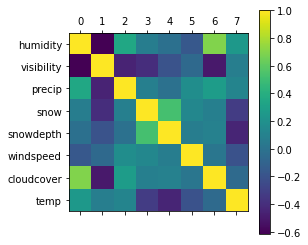

In [18]:
weather=pd.read_csv('nyc 2021-01-01 to 2021-12-31.csv')
weatherdata=weather[['datetime', 'humidity', 'visibility', 'precip', 'snow',
       'snowdepth','windspeed','cloudcover', 'temp']]
w=weatherdata.corr()
we=plt.matshow(w)
plt.colorbar(we)
labels =['humidity', 'visibility', 'precip', 'snow',
       'snowdepth','windspeed',
       'cloudcover','temp']
plt.yticks(np.arange(len(labels)), labels)
w

## FINDING THE  RELATION BETWEEN WEATHER AND UBER EARNINGS

0:10:18.017922


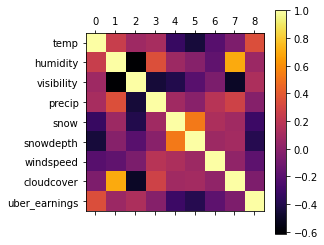

,temp,humidity,visibility,precip,snow,snowdepth,windspeed,cloudcover,uber
temp,1.000000,0.249578,0.074539,0.116416,-0.323547,-0.447227,-0.203916,-0.055964,0.342340
humidity,0.249578,1.000000,-0.612629,0.350970,0.068964,-0.018511,-0.170986,0.696128,0.061653
visibility,0.074539,-0.612629,1.000000,-0.450561,-0.403306,-0.198394,-0.064097,-0.499583,0.132385
precip,0.116416,0.350970,-0.450561,1.000000,0.080615,-0.013178,0.180164,0.281845,-0.025721
snow,-0.323547,0.068964,-0.403306,0.080615,1.000000,0.523152,0.134535,0.082155,-0.306731
snowdepth,-0.447227,-0.018511,-0.198394,-0.013178,0.523152,1.000000,0.071174,0.096436,-0.390287
windspeed,-0.203916,-0.170986,-0.064097,0.180164,0.134535,0.071174,1.000000,0.021172,-0.182761
cloudcover,-0.055964,0.696128,-0.499583,0.281845,0.082155,0.096436,0.021172,1.000000,-0.054332
uber,0.342340,0.061653,0.132385,-0.025721,-0.306731,-0.390287,-0.182761,-0.054332,1.000000


In [37]:
import datetime
startTime = datetime.datetime.now()
earning=[]
for filename in os.listdir('./data/'):
    file_path = os.path.join('./data/', filename)
    data = pq.read_table(file_path)
    data=data.to_pandas()
    uber=data[data['hvfhs_license_num']=="HV0003"]
    uber['date']=uber['on_scene_datetime'].dt.day
    uber['airport_fee'].fillna(0, inplace=True)
    uber['uber_earnings']=uber['base_passenger_fare']+uber['tolls']+uber['congestion_surcharge']+uber['tips']-uber['driver_pay']-uber['airport_fee']-uber['sales_tax']
    data=uber.groupby('date').sum()
    data=data['uber_earnings']
    for i in data:
        earning.append(i)
endTime = datetime.datetime.now()
print(endTime - startTime)

weather=pd.read_csv('nyc 2021-01-01 to 2021-12-31.csv')
weather['uber']=earning[:365]
weather=weather[[ 'temp', 'humidity', 'visibility', 'precip', 'snow',
       'snowdepth','windspeed',
       'cloudcover','uber']]
weatherdata=weather.corr()

w=plt.matshow(weatherdata,cmap='inferno')
plt.colorbar(w)
labels =[ 'temp', 'humidity', 'visibility', 'precip', 'snow',
       'snowdepth','windspeed',
       'cloudcover','uber_earnings']
plt.yticks(np.arange(len(labels)), labels)
plt.show()
weatherdata

## CONCATING LAST 2 MONTHS DATASETS

In [2]:
import datetime
startTime = datetime.datetime.now()
quarterdata=pd.DataFrame()
for file in ['./data/fhvhv_tripdata_2021-11.parquet','./data/fhvhv_tripdata_2021-12.parquet']:
    uber=pq.read_table(file)
    uber=uber.to_pandas()
    uber=uber[uber['hvfhs_license_num']=="HV0003"]
    uber['date']=uber['on_scene_datetime'].dt.day
    uber['hrs']=uber['pickup_datetime'].dt.hour
    uber['day']=uber['pickup_datetime'].dt.day_name()
    uber['uber_earnings']=uber['base_passenger_fare']+uber['tolls']+uber['congestion_surcharge']+uber['tips']-uber['driver_pay']-uber['airport_fee']+uber['sales_tax']
    uber['request_datetime']=pd.to_datetime(uber['request_datetime'])
    uber['pick_drop_time'] = pd.to_datetime(uber['dropoff_datetime'], format='%H:%M:%S') - pd.to_datetime(uber['pickup_datetime'], format='%H:%M:%S')
    uber['request_onseen'] = pd.to_datetime(uber['on_scene_datetime'], format='%M') - pd.to_datetime(uber['request_datetime'], format='%M')
    uber['base_passenger_fare'] = uber['base_passenger_fare'].abs()
    uber['driver_pay']=uber['driver_pay'].abs()
    uber['uber_earnings']=uber['uber_earnings'].abs()
    uber=uber[['trip_miles','pickup_datetime',
       'trip_time', 'base_passenger_fare', 'tolls', 'sales_tax',
       'congestion_surcharge', 'airport_fee', 'tips', 'driver_pay',
       'date', 'hrs', 'day','pick_drop_time', 'request_onseen', 'uber_earnings']]
    quarterdata=pd.concat([quarterdata,uber])
quarterdata.to_csv("quarterdata.csv",index=False)
endTime = datetime.datetime.now()
print(endTime - startTime)

0:11:58.783422


In [3]:
data = pd.read_csv('quarterdata.csv')
data.head()
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['sincestart'] = (data['pickup_datetime'].dt.date - data['pickup_datetime'].min().date()).dt.days

## BUILDNG AND TRAILING A MODEL


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
features = ['sincestart', 'trip_miles', 'base_passenger_fare', 'tolls', 'sales_tax', 'congestion_surcharge', 'airport_fee', 'tips', 'driver_pay']
x= data[features]
y = data['uber_earnings']
 
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

model = LinearRegression()
model.fit(X_train, y_train)

predictions = model.predict(X_test)
model.score(X_test, y_test)

0.9261372630201493

## PREDICTION ACCURECY


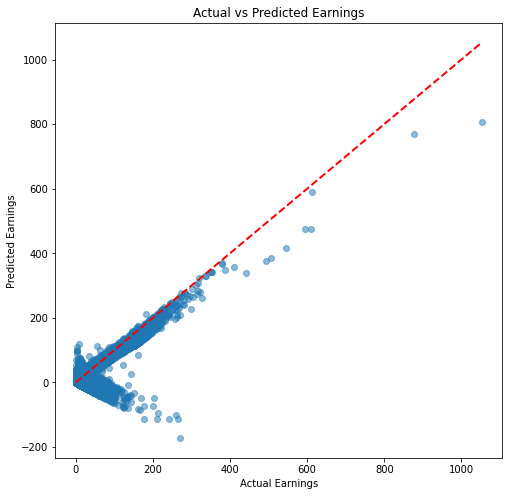

In [12]:

plt.figure(figsize=(8, 8))
plt.scatter(y_test, predictions, alpha=0.5)  
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2)  
plt.title('Actual vs Predicted Earnings')
plt.xlabel('Actual Earnings')
plt.ylabel('Predicted Earnings')
plt.show()


## After reducing the data

In [9]:
data = pd.read_csv('quarterdata.csv')
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['sincestart'] = (data['pickup_datetime'].dt.date - data['pickup_datetime'].min().date()).dt.days
data['month_day'] = data['pickup_datetime'].dt.strftime('%Y-%m-%d')
avg_data = data.groupby('month_day').agg({
    'trip_miles': 'sum',
    'trip_time': 'mean',
    'base_passenger_fare': 'sum',
    'tolls': 'sum',
    'sales_tax': 'sum',
    'congestion_surcharge': 'sum',
    'airport_fee': 'sum',
    'tips': 'sum',
    'driver_pay': 'sum',
    'uber_earnings': 'sum',
    'sincestart': 'first'  
}).reset_index()

print(avg_data)


     month_day  trip_miles    trip_time  base_passenger_fare      tolls  \
0   2021-11-01  1761185.53  1181.939512           8315491.35  396212.80   
1   2021-11-02  1594889.17  1078.964907           7247317.43  341410.48   
2   2021-11-03  1685076.64  1181.595752           8065606.82  364971.93   
3   2021-11-04  1887012.88  1198.919102           8981734.38  421619.48   
4   2021-11-05  2066640.46  1225.251796           9982093.73  449478.30   
..         ...         ...          ...                  ...        ...   
56  2021-12-27  1307596.28   974.070509           5289530.55  268498.93   
57  2021-12-28  1311990.39   995.988536           5343671.80  269364.98   
58  2021-12-29  1382024.44  1003.036033           5671103.86  284566.08   
59  2021-12-30  1520332.87  1027.039884           6227090.86  320540.01   
60  2021-12-31  1718629.34   947.739330           6873912.66  324410.37   

    sales_tax  congestion_surcharge  airport_fee       tips  driver_pay  \
0   715123.27           

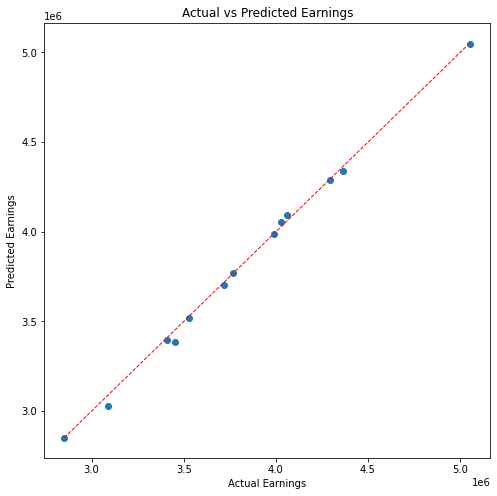

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
features = ['sincestart', 'trip_miles', 'base_passenger_fare', 'tolls', 'sales_tax', 'congestion_surcharge', 'airport_fee', 'tips', 'driver_pay']
x= avg_data[features]
y = avg_data['uber_earnings']
 
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

model = LinearRegression()
model.fit(X_train, y_train)

predictions = model.predict(X_test)
print("model score:",model.score(X_test, y_test))
plt.figure(figsize=(8, 8))
plt.scatter(y_test, predictions,)  
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=1)  
plt.title('Actual vs Predicted Earnings')
plt.xlabel('Actual Earnings')
plt.ylabel('Predicted Earnings')
plt.show()

# TIME SERIES FORECASTING [PREDICTING NEXT 30 DAYS]

Predicted Earnings for the Future:
[3024990.78139655 3790494.37474373 4819223.84700307 2523964.5855573
 2938706.68103926 3989203.68994097 3322680.34529803 3862369.23524982
 4253255.32521135 3305339.58528415 4328071.41175763 6016518.03268753
 5715912.84457746 5391287.62389992 6774140.03618426 5806126.92115398
 4618192.88537788 2287901.71115179 6012389.38735639 4564361.25147889
 5563579.16777307 4122032.52925143 1986023.63939748 5011397.02251551
 5047263.66805421 3763863.46648628 6306841.87463162 4939834.60235765
 2059779.00230633 4342714.0179022 ]


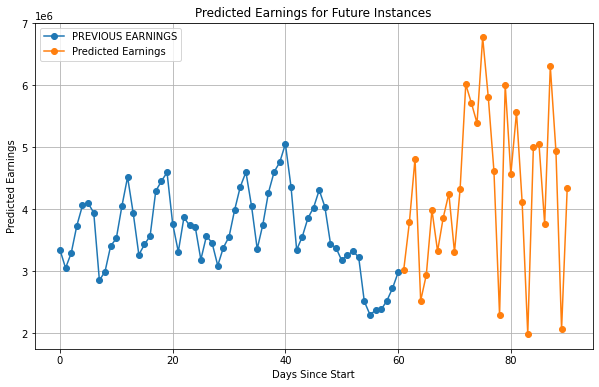

In [12]:
future_data = pd.DataFrame({
    'sincestart': np.arange(max(data['sincestart']) + 1, max(data['sincestart']) + 31),  
    'trip_miles': np.random.uniform(low=avg_data['trip_miles'].mean(), high=avg_data['trip_miles'].max(), size=30), 
    'base_passenger_fare': np.random.uniform(low=avg_data['base_passenger_fare'].mean(), high=avg_data['base_passenger_fare'].max(), size=30),  
    'tolls': np.random.uniform(low=avg_data['tolls'].mean(), high=avg_data['tolls'].max(), size=30), 
    'sales_tax': np.random.uniform(low=avg_data['sales_tax'].mean(), high=avg_data['sales_tax'].max(), size=30),
    'congestion_surcharge': np.random.uniform(low=avg_data['congestion_surcharge'].mean(), high=avg_data['congestion_surcharge'].max(), size=30),  
    'airport_fee': np.random.uniform(low=avg_data['airport_fee'].mean(), high=avg_data['airport_fee'].max(), size=30),
    'tips': np.random.uniform(low=avg_data['tips'].mean(), high=avg_data['tips'].max(), size=30),
    'driver_pay': np.random.uniform(low=avg_data['driver_pay'].mean(), high=avg_data['driver_pay'].max(), size=30)  
})

future_predictions = model.predict(future_data[features])

print("Predicted Earnings for the Future:")
print(future_predictions)
plt.figure(figsize=(10, 6))
plt.plot(avg_data['sincestart'], avg_data['uber_earnings'], marker='o', label='PREVIOUS EARNINGS')
plt.plot(future_data['sincestart'], future_predictions, marker='o', label='Predicted Earnings')

plt.title('Predicted Earnings for Future Instances')
plt.xlabel('Days Since Start')
plt.ylabel('Predicted Earnings')
plt.legend()
plt.grid(True)

plt.show()

# CALCULATING THE REVENUE OF UBER 

In [7]:
import datetime
startTime = datetime.datetime.now()
uber_earnings=[]
drivers_pay=[]
taxes=[]

for filename in os.listdir('./data/'):
    file_path = os.path.join('./data/', filename)
    data = pq.read_table(file_path)
    data=data.to_pandas()
    uber=data[data['hvfhs_license_num']=="HV0003"]
    uber['airport_fee'].fillna(0, inplace=True)
    uber['uber_earnings']=uber['base_passenger_fare']+uber['tolls']+uber['congestion_surcharge']+uber['tips']-uber['driver_pay']-uber['airport_fee']-uber['sales_tax']
    print("TOTAL EARNINGS IN THIS MONTH:",round(uber['uber_earnings'].sum()))
    uber_earnings.append(uber['uber_earnings'].sum())
    drivers_pay.append(uber['driver_pay'].sum())
    taxes.append(uber['sales_tax'].sum())
    
print("TOTAL UBER EARNINGS THIS YEAR:",sum(uber_earnings),"\n TOTAL SUM OF DRIVERS PAY:",sum(drivers_pay),"\nTOTAL TAXES RECIEVED THIS YEAR",sum(taxes))
endTime = datetime.datetime.now()
print("TOTAL TIME FOR EXECUTING THIS CODE",endTime - startTime)
    

TOTAL EARNINGS IN THIS MONTH: 30020228
TOTAL EARNINGS IN THIS MONTH: 26810243
TOTAL EARNINGS IN THIS MONTH: 36448319
TOTAL EARNINGS IN THIS MONTH: 44515842
TOTAL EARNINGS IN THIS MONTH: 46464159
TOTAL EARNINGS IN THIS MONTH: 51195093
TOTAL EARNINGS IN THIS MONTH: 56884967
TOTAL EARNINGS IN THIS MONTH: 52121228
TOTAL EARNINGS IN THIS MONTH: 51231113
TOTAL EARNINGS IN THIS MONTH: 49626414
TOTAL EARNINGS IN THIS MONTH: 58022697
TOTAL EARNINGS IN THIS MONTH: 63164271
TOTAL UBER EARNINGS THIS YEAR: 566504574.1099999 
 TOTAL SUM OF DRIVERS PAY: 2288988531.8599987 
TOTAL TAXES RECIEVED THIS YEAR 235272002.90000004
TOTAL TIME FOR EXECUTING THIS CODE 0:08:22.330055


In [41]:
print("TOTAL UBER EARNINGS THIS YEAR:",locale.currency(566504574.1099999,grouping=True),"\n TOTAL SUM OF DRIVERS PAY:",locale.currency(2288988531.8599987,grouping=True),"\nTOTAL TAXES RECIEVED THIS YEAR",locale.currency(235272002.90000004,grouping=True))


TOTAL UBER EARNINGS THIS YEAR: $566,504,574.11 
 TOTAL SUM OF DRIVERS PAY: $2,288,988,531.86 
TOTAL TAXES RECIEVED THIS YEAR $235,272,002.90


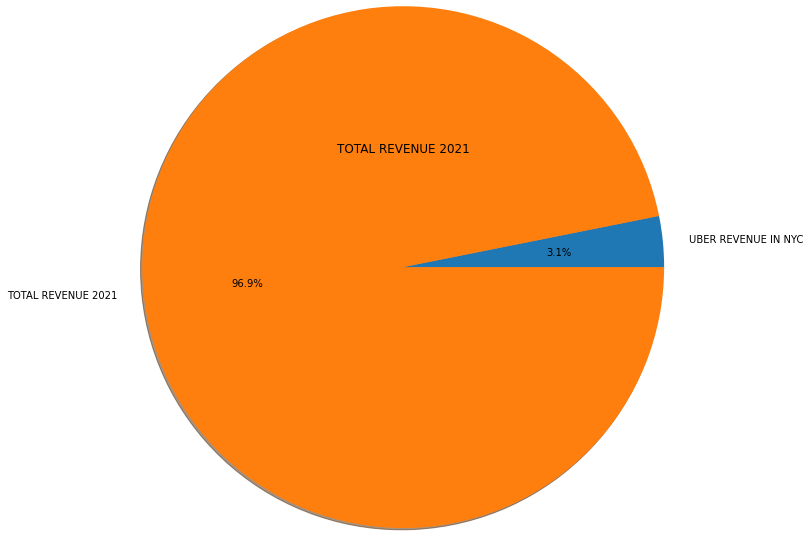

In [9]:
uber_earnings=566504574
plt.pie([uber_earnings,17455000000],labels=["UBER REVENUE IN NYC","TOTAL REVENUE 2021"],shadow = True, radius = 3, autopct = '%1.1f%%')
plt.title('TOTAL REVENUE 2021')
plt.show()

# OTHER COMPITATORS

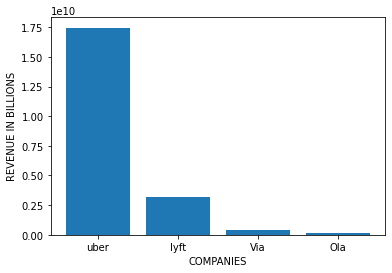

In [7]:
plt.bar(['uber','lyft','Via','Ola'],[17455000000,3200000000,393000000,117620972])
plt.xlabel("COMPANIES")
plt.ylabel("REVENUE IN BILLIONS")
plt.show()

# REVENUE EARNED BY UBER FROM 2014 - 2022

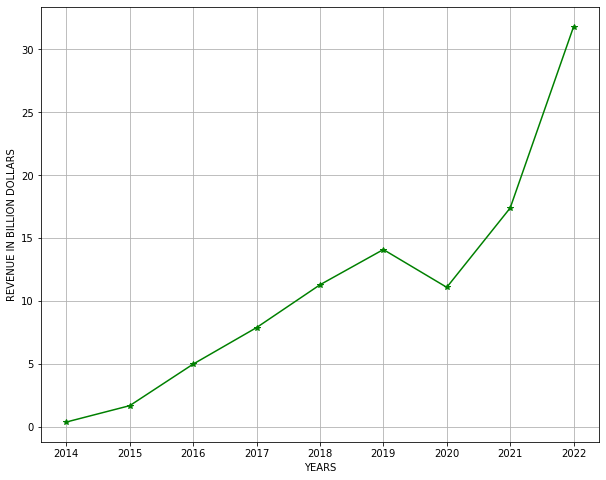

In [9]:
plt.figure(figsize=(10,8))
plt.plot(['2014','2015','2016','2017','2018','2019','2020','2021','2022'],[0.4,1.7,5,7.9,11.3,14.1,11.1,17.4,31.8],marker="*",color='green')
plt.xlabel("YEARS")
plt.ylabel("REVENUE IN BILLION DOLLARS")
plt.grid(True)
plt.show()